In [28]:
!pip install wandb
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.layers import Dense,MaxPool2D,Flatten,Conv2D
import os
from tensorflow.keras import layers
from wandb.keras import WandbCallback
import wandb
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
!pip install kaggle

In [30]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [31]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

face-mask-12k-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [32]:
!unzip -qq face-mask-12k-images-dataset.zip

replace Face Mask Dataset/Test/WithMask/1163.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [33]:
dataset_train='/content/Face Mask Dataset/Train'
dataset_test='/content/Face Mask Dataset/Test'
dataset_val='/content/Face Mask Dataset/Validation'
width=height=128
batch_size=32

In [34]:
data_generator=ImageDataGenerator(
rescale=1/255,
horizontal_flip=True,
)


In [35]:
train_data=data_generator.flow_from_directory(
    dataset_train,
    target_size=(width,height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)
val_data = data_generator.flow_from_directory(dataset_val,
                                                    target_size = (width, height),
                                                    class_mode = 'categorical',
                                                    batch_size = batch_size,
                                                    shuffle = False
                                                    )
test_data=data_generator.flow_from_directory(
    dataset_test,
    target_size=(width,height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
  
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [36]:
base_model = tf.keras.applications.VGG16(
    input_shape=(width, height, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'max'
    )

In [37]:
model = tf.keras.Sequential([
        base_model,
        
        layers.Dense(128, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(2, activation='sigmoid'),              
])

In [38]:
wandb.init(project="Mask_detection")

In [39]:
config = wandb.config
config.learning_rate = 0.001
model.compile(
    loss=tf.keras.losses.binary_crossentropy,optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
    metrics=['accuracy']
)

In [45]:
model.fit(train_data,
          steps_per_epoch = train_data.samples / batch_size,
          validation_data = val_data,
          validation_steps = val_data.samples / batch_size,
          epochs = 10
)



Epoch 1/10
312/312 [==============================] - 84s 269ms/step - loss: 0.0469 - accuracy: 0.9855 - val_loss: 0.0396 - val_accuracy: 0.9837
Epoch 2/10
312/312 [==============================] - 84s 269ms/step - loss: 0.0449 - accuracy: 0.9837 - val_loss: 0.0782 - val_accuracy: 0.9725
Epoch 3/10
312/312 [==============================] - 84s 269ms/step - loss: 0.0404 - accuracy: 0.9864 - val_loss: 0.1279 - val_accuracy: 0.9600
Epoch 4/10
312/312 [==============================] - 84s 269ms/step - loss: 0.0329 - accuracy: 0.9881 - val_loss: 0.3004 - val_accuracy: 0.9325
Epoch 5/10
312/312 [==============================] - 84s 269ms/step - loss: 0.0392 - accuracy: 0.9853 - val_loss: 0.0223 - val_accuracy: 0.9900
Epoch 6/10
312/312 [==============================] - 84s 268ms/step - loss: 0.0378 - accuracy: 0.9863 - val_loss: 0.0173 - val_accuracy: 0.9925
Epoch 7/10
312/312 [==============================] - 84s 269ms/step - loss: 0.0357 - accuracy: 0.9885 - val_loss: 0.0174 - val_ac

In [46]:
model.evaluate(test_data)

31/31 [==============================] - 3s 92ms/step - loss: 0.0361 - accuracy: 0.9859


[0.036100126802921295, 0.9858871102333069]

In [47]:
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis= 1)

print(confusion_matrix(test_data.classes, y_pred))
targets = set(test_data.class_indices.keys())
print('classification_report:')
print(classification_report(test_data.classes, y_pred, target_names= targets))

[[481   2]
 [ 11 498]]
classification_report:
              precision    recall  f1-score   support

    WithMask       0.98      1.00      0.99       483
 WithoutMask       1.00      0.98      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



In [48]:
!pip install retina-face
from retinaface import RetinaFace
import cv2
import matplotlib.pyplot as plt

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14273 sha256=24faa72d9d2bddcf94e2516ca33df58c6ca07f4d08d6ac8e47d18c1644221769
  Stored in directory: /root/.cache/pip/wheels/8c/17/ff/58721d1fabdb87c21a0529948cf39e2be9af90ddbe4ad65944
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


In [49]:
def predict(image_path):
    faces = RetinaFace.extract_faces(img_path= image_path, align= True)
    image = faces[0]
    image = cv2.resize(image, (width, height))
    plt.imshow(image)
    image = image / 255.0
    image = np.expand_dims(image, axis= 0)
    res = np.argmax(model.predict(image))
    if res == 0:
        print('with mask\n')
    else:
        print('no mask\n')

Directory  /root /.deepface created
Directory  /root /.deepface/weights created
retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:01<00:00, 75.4MB/s]


no mask



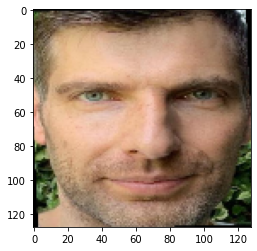

In [50]:
predict('1.jpg')

with mask



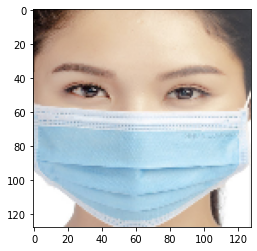

In [51]:
predict('2.jpg')